In [45]:
import numpy as np #tính toán số học
import pandas as pd # xử lí dữ liệu dạng bảng
import matplotlib.pyplot as plt # vẽ đồ thị
import seaborn as sns #trực quan hóa dữ liệu mở rộng của matplotlib
import plotly.express as px # vẽ biểu đồ tròn, cột
import plotly.graph_objects as go #tùy chỉnh thành phần trên từng đồ thị
from plotly.subplots import make_subplots #tổ chức và hiển thị nhiều đồ thị trong 1 cửa sổ
import os #tương tác vs hệ thống file/tệp
import random #tạo số ngẫu nhiên
import time
from PIL import Image, ImageEnhance, ImageOps #Xử lí ảnh
from tqdm import tqdm #thanh hiển thị trạng thái
from typing import Tuple, List, Dict, Optional
from sklearn.metrics import confusion_matrix
from sklearn import metrics

sns.set_style('darkgrid')

ĐƯỜNG DẪN DATA

In [46]:
TRAINING_DATA_DIR = 'C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelAI/Model-AI--Fire-Detection-using-CNN/Train1'
TESTING_DATA_DIR = 'C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelAI/Model-AI--Fire-Detection-using-CNN/Test'
MAX_ROWS_PER_CATEGORY = 5000

In [47]:
meta_data = [] #Khởi tạo danh sách lưu về thông tin từng hình ảnh

#Lặp qua 2 thư mục fire và non_fire
for subdir in ["fire", "non_fire"]: #Nhận 2 giá trị fire hay non_fire
    curr_dir = os.path.join(TRAINING_DATA_DIR, subdir) #Đường dẫn tới thư mục
    
    #Duyệt qua từng file với chỉ số index tương ứng
    for index, filename in enumerate(os.listdir(curr_dir)):
        if index >= MAX_ROWS_PER_CATEGORY:
            break
        full_path = os.path.join(curr_dir, filename) #Tạo đường dẫn đầy đủ tới file
        
        #Tải hình ảnh từ đường dẫn và lấy thông tin ảnh
        shape = Image.open(full_path).size
        height = shape[1]
        width = shape[0]
        
        #Thêm 1 danh sách vào meta_data
        meta_data.append([full_path, subdir,  height, width])
        
#Chuyển danh sách meta_data thành 1 Dataframe        
df = pd.DataFrame(meta_data, columns=['path','label', 'height', 'width'])
df = df.sample(frac=1).reset_index(drop=True) #Xáo trộn(100%) các dòng trong dataframe rồi đặt lại chỉ số
df.head(10)


,path,label,height,width
0,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,non_fire,332,500
1,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,fire,555,740
2,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,fire,394,700
3,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,non_fire,600,400
4,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,non_fire,350,605
5,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,fire,485,674
6,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,non_fire,360,640
7,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,fire,540,720
8,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,fire,633,950
9,C:/Users/ADMIN/OneDrive/Tài liệu/CODE/ModelA...,non_fire,267,400


BIỂU DIỄN TRỰC QUAN ẢNH TRONG TẬP TRAIN

In [48]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])
#Tạo 1 biểu đồ cột và 1 biểu đồ tròn

fig.add_trace(go.Bar(x =df['label'].value_counts().index, #lấy các nhãn label trên trục x
                     y=df['label'].value_counts().to_numpy(), #lấy số lượng từng nhãn tương ứng trên trục y
                     marker_color=['darkorange','green'],showlegend=False),#màu sắc mỗi cột
                     row=1,col=1)# đặt biểu đồ ở hàng 1 cột 1

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),#Giá trị để tạo tỷ lệ trong biểu đồ tròn
     labels=df['label'].value_counts().index, #Nhãn tương ứng 
    marker=dict(colors=['darkorange','green'])),#màu sắc
    row=1, col=2)


HIỂN THỊ 1 SỐ ẢNH CHÁY

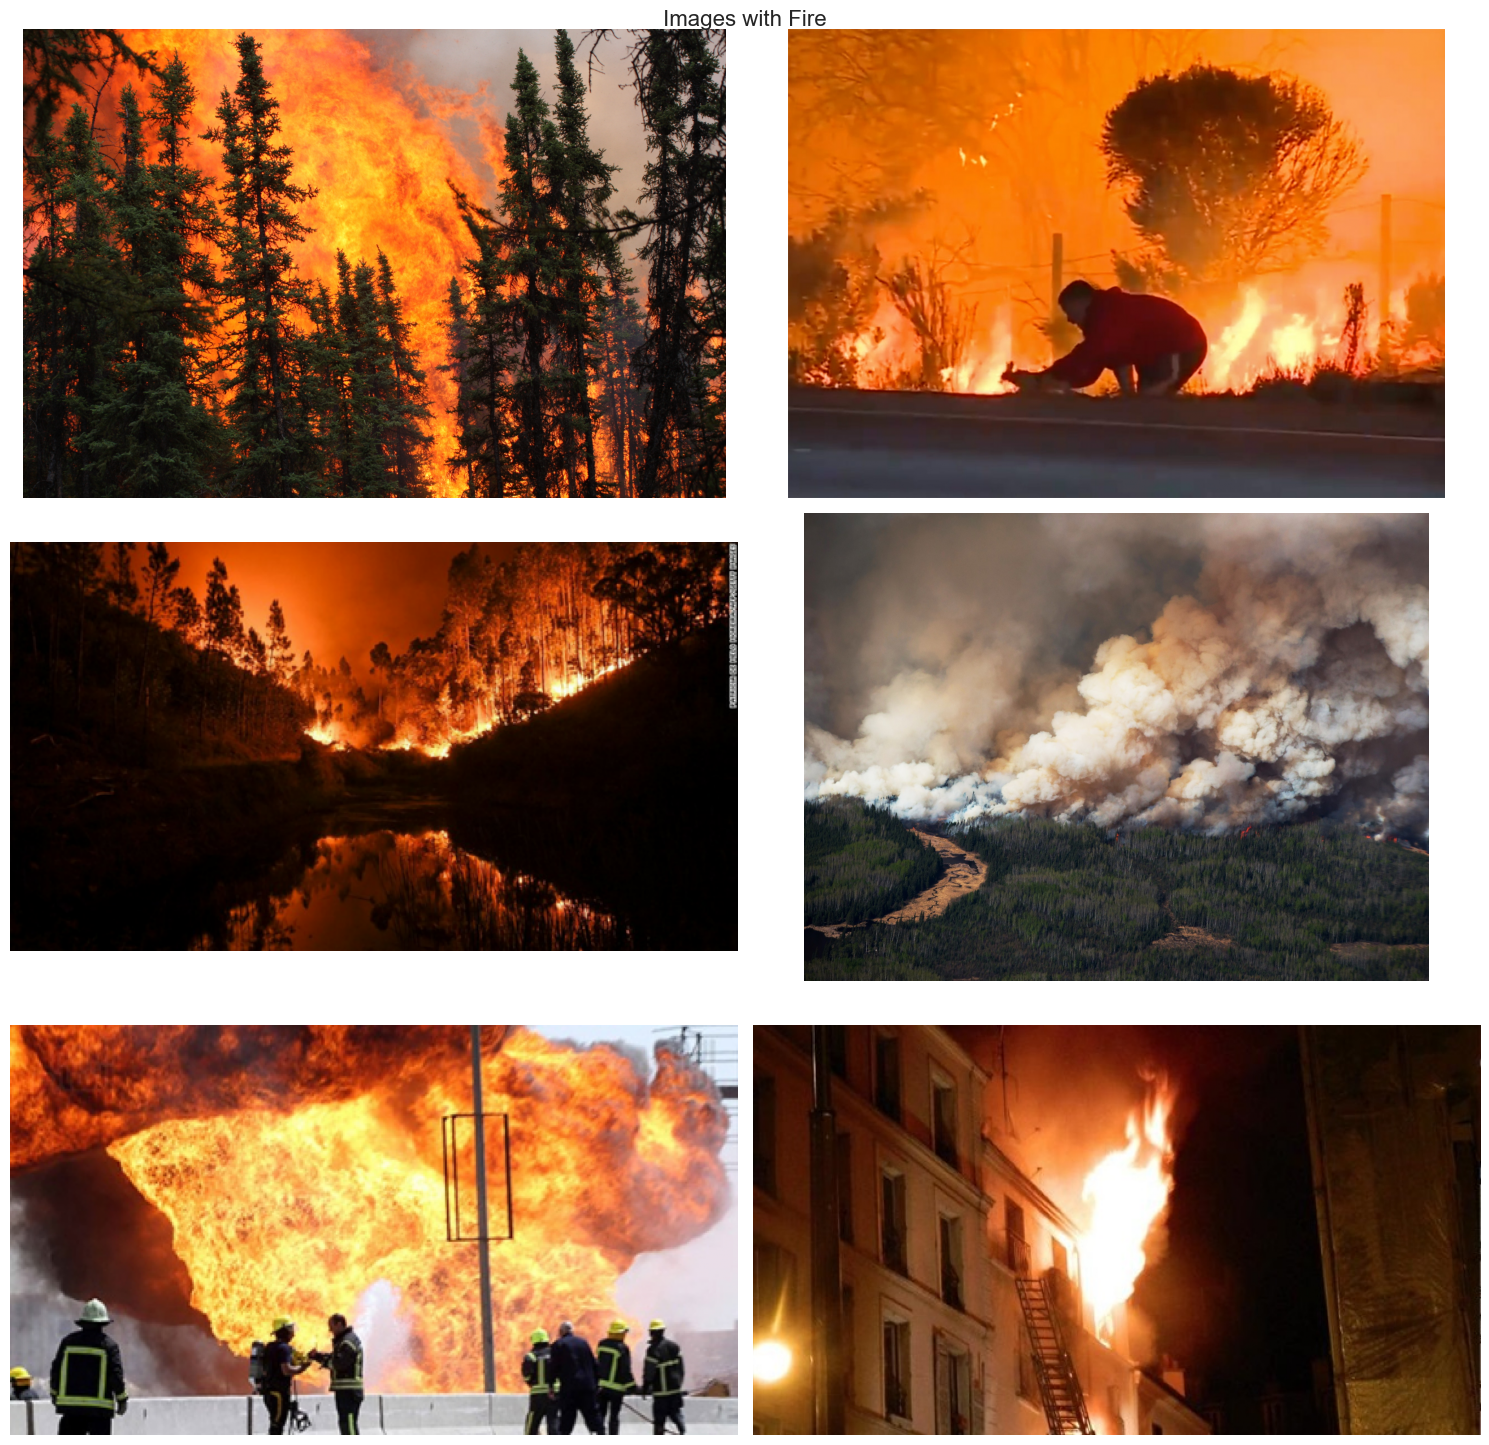

In [49]:
label = 'fire'  # Định nghĩa nhãn (label) cho ảnh có lửa
data = df[df['label'] == label]  # Lọc dữ liệu để lấy các hàng có nhãn là 'fire'
sns.set_style('dark')  # Thiết lập phong cách hiển thị của đồ thị thành 'dark'

pics = 6  # Số lượng ảnh muốn hiển thị

# Tạo một khung hình với các subplot
fig, ax = plt.subplots(int(pics / 2), 2, figsize=(15, 15))  # Tạo grid subplot (3x2) với kích thước 15x15
ax = ax.ravel()  # Chuyển mảng 2D của các axes thành mảng 1D để dễ dàng truy cập qua chỉ số

# Vòng lặp qua số lượng ảnh cần hiển thị
for i in range(int(pics / 2) * 2):  # Lặp qua tất cả các subplot
    try:
        # Lấy một đường dẫn ngẫu nhiên từ dữ liệu
        path = data.sample(1).iloc[0]['path']  # Chọn ngẫu nhiên một hàng từ dữ liệu và lấy đường dẫn ảnh
        
        img = Image.open(path)  # Mở ảnh từ đường dẫn
        
        # Chuyển ảnh thành mảng và chuẩn hóa giá trị pixel về khoảng [0, 1]
        img_array = np.array(img) / 255.0  # Chia giá trị pixel cho 255 để chuẩn hóa
        
        # Hiển thị ảnh trên subplot
        ax[i].imshow(img_array)  # Hiển thị ảnh trên trục con
        ax[i].axis('off')  # Tắt hiển thị các trục x và y
    except Exception as e:  # Xử lý ngoại lệ khi xảy ra lỗi
        print(f"Error loading image {i}: {str(e)}")  # In ra lỗi nếu không thể tải ảnh

# Thêm tiêu đề chung cho toàn bộ hình
plt.suptitle('Images with Fire', fontsize=16)  # Tiêu đề chính của hình
plt.tight_layout()  # Điều chỉnh khoảng cách giữa các subplot để tránh bị chồng chéo
plt.show()  # Hiển thị toàn bộ hình


TIỀN XỬ LÍ ẢNH

In [50]:
# RESIZE ẢNH

def process_image(path, size=(256, 256)):
    try:
        with Image.open(path) as img: #mở ảnh từ đường dẫn
            img = img.convert("RGB")  # Chuyển sang định dạng RGB
            img = ImageOps.fit(img, size, Image.Resampling.LANCZOS)  # Resize với padding
            return np.asarray(img, dtype=np.float64) / 255.0  # Chuẩn hóa pixel về khoảng [0, 1]
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None

# Hàm tăng cường dữ liệu (augmentation)
def augment_image(image):
    try:
        # Xoay ảnh ngẫu nhiên(xoay góc ngẫu nhiên trong khoảng -25,25 độ)
        angle = random.uniform(-25, 25)
        image = image.rotate(angle, resample=Image.BICUBIC) #xoay ảnh với resample chất lượng cao

        # Dịch chuyển ảnh
        max_dx, max_dy = int(0.1 * image.size[0]), int(0.1 * image.size[1]) # Tính khoảng dịch chuyển tối đa (10% kích thước ảnh)
        dx, dy = random.randint(-max_dx, max_dx), random.randint(-max_dy, max_dy)  # Lấy ngẫu nhiên giá trị dịch chuyển
        image = image.transform(
            image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy), resample=Image.BICUBIC
        ) #dịch chuyển ảnh theo ma trận biến đổi Affine

        # Cắt xiên ảnh
        shear = random.uniform(-0.05, 0.05) #hệ số xiên ngẫu nhiên
        image = image.transform(
            image.size, Image.AFFINE, (1, shear, 0, shear, 1, 0), resample=Image.BICUBIC
        )

        # Phóng to hoặc thu nhỏ
        scale = random.uniform(0.8, 1.2) #tỉ lệ phóng to/thu nhỏ
        new_size = (int(image.size[0] * scale), int(image.size[1] * scale))# tính kích thước mới
        image = image.resize(new_size, resample=Image.BICUBIC)#resize ảnh

        # Cắt hoặc padding về kích thước chuẩn
        if scale > 1:
            image = ImageOps.fit(image, image.size, Image.ANTIALIAS)
        else: #nếu ảnh bị thu nhỏ, thêm padding đen
            padded_img = Image.new("RGB", image.size, (0, 0, 0)) #tạo 1 ảnh nền đen
            padded_img.paste(image, (0, 0))#dán ảnh gốc lên ảnh nền
            image = padded_img

        # Lật ngẫu nhiên
        if random.random() < 0.5: #50% khả năng lật ngang
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        return image #trả về ảnh đã tăng cường
    except Exception as e:
        
        return image #nếu có lỗi, trả ảnh gốc


# Xây dựng dữ liệu từ DataFrame
df = pd.DataFrame({
    "path": [os.path.join(TRAINING_DATA_DIR, "fire", f) for f in os.listdir(os.path.join(TRAINING_DATA_DIR, "fire"))] +
            [os.path.join(TRAINING_DATA_DIR, "non_fire", f) for f in os.listdir(os.path.join(TRAINING_DATA_DIR, "non_fire"))],
    "label": ["fire"] * len(os.listdir(os.path.join(TRAINING_DATA_DIR, "fire"))) +
             ["non_fire"] * len(os.listdir(os.path.join(TRAINING_DATA_DIR, "non_fire")))
})

# Xử lý dữ liệu và loại bỏ ảnh bị lỗi
processed_images = []
processed_labels = []

for _, row in df.iterrows(): #lặp qua từng dòng trong dataframe
    img = process_image(row["path"]) #resize và chuẩn hóa ảnh
    if img is not None:#nếu ảnh không lỗi 
        # Tăng cường dữ liệu ngẫu nhiên cho một phần ảnh
        
        if random.random() < 0.5: # 50% ảnh sẽ được tăng cường dữ liệu
            img = augment_image(Image.fromarray((img * 255).astype(np.uint8))) #tăng cường dữ liệu
            img = img.resize((256, 256), resample=Image.Resampling.LANCZOS) #resize lại về kích thước chuẩn
            img = np.asarray(img, dtype=np.float64) / 255.0 #chuẩn hóa pixel

        processed_images.append(img) #thêm ảnh đã xử lí vào
        processed_labels.append(1 if row["label"] == "fire" else 0) #thêm nhãn


#Chuyển danh sách thành mảng numpy
X = np.array(processed_images, dtype=np.float32) 
y = np.array(processed_labels, dtype=np.float32)

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]
print(f"So luong mau train: {len(X_train)}")
print(f"So luong mau kiem tra: {len(X_val)}")


So luong mau train: 806
So luong mau kiem tra: 202


XÂY DỰNG MÔ HÌNH

In [51]:

class Layer:
    def forward(self, input_data):
        pass
    
    def backward(self, gradient):
        pass

class Conv2D(Layer):
    def __init__(self, filters, kernel_size, input_shape=None):
        self.filters = filters
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.input_shape = input_shape
        self.weights = None
        self.biases = None
        
    def initialize_weights(self, input_shape):
        k_h, k_w = self.kernel_size
        c = input_shape[-1]
        # Xavier/Glorot initialization
        limit = np.sqrt(2.0 / (k_h * k_w * c))
        self.weights = np.random.uniform(-limit, limit, (self.filters, k_h, k_w, c))
        self.biases = np.zeros((self.filters,))
        
    def forward(self, input_data):
        if self.weights is None:
            self.initialize_weights(input_data.shape)
            
        self.input = input_data
        batch_size, in_h, in_w, _ = input_data.shape
        k_h, k_w = self.kernel_size
        
        out_h = in_h - k_h + 1
        out_w = in_w - k_w + 1
        
        output = np.zeros((batch_size, out_h, out_w, self.filters))
        
        # Optimized convolution operation
        for f in range(self.filters):
            for i in range(out_h):
                for j in range(out_w):
                    output[:, i, j, f] = np.sum(
                        input_data[:, i:i+k_h, j:j+k_w, :] * self.weights[f],
                        axis=(1,2,3)
                    ) + self.biases[f]
        
        return output
    
    def backward(self, gradient):
        batch_size = self.input.shape[0]
        k_h, k_w = self.kernel_size
        
        self.d_weights = np.zeros_like(self.weights)
        self.d_biases = np.sum(gradient, axis=(0,1,2))
        
        d_input = np.zeros_like(self.input)
        
        for f in range(self.filters):
            for i in range(gradient.shape[1]):
                for j in range(gradient.shape[2]):
                    d_input[:, i:i+k_h, j:j+k_w, :] += (
                        self.weights[f] * gradient[:, i, j, f, np.newaxis, np.newaxis, np.newaxis]
                    )
                    self.d_weights[f] += np.sum(
                        self.input[:, i:i+k_h, j:j+k_w, :] * 
                        gradient[:, i, j, f, np.newaxis, np.newaxis, np.newaxis],
                        axis=0
                    )
        
        return d_input

class MaxPool2D(Layer):
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size
        
    def forward(self, input_data):
        self.input = input_data
        batch_size, h, w, c = input_data.shape
        p_h, p_w = self.pool_size
        
        out_h = h // p_h
        out_w = w // p_w
        
        output = np.zeros((batch_size, out_h, out_w, c))
        self.mask = np.zeros_like(input_data)
        
        for i in range(out_h):
            for j in range(out_w):
                h_start, h_end = i*p_h, (i+1)*p_h
                w_start, w_end = j*p_w, (j+1)*p_w
                
                slice_input = input_data[:, h_start:h_end, w_start:w_end, :]
                output[:, i, j, :] = np.max(slice_input, axis=(1,2))
                
                # Create boolean mask for backprop
                for b in range(batch_size):
                    for ch in range(c):
                        max_val = output[b, i, j, ch]
                        mask = slice_input[b, :, :, ch] == max_val
                        self.mask[b, h_start:h_end, w_start:w_end, ch] = mask
        
        return output
    
    def backward(self, gradient):
        d_input = np.zeros_like(self.input)
        batch_size, h, w, c = self.input.shape
        p_h, p_w = self.pool_size
        
        out_h = h // p_h
        out_w = w // p_w
        
        for i in range(out_h):
            for j in range(out_w):
                h_start, h_end = i*p_h, (i+1)*p_h
                w_start, w_end = j*p_w, (j+1)*p_w
                
                d_input[:, h_start:h_end, w_start:w_end, :] += (
                    self.mask[:, h_start:h_end, w_start:w_end, :] * 
                    gradient[:, i:i+1, j:j+1, :]
                )
                
        return d_input

class Flatten(Layer):
    def forward(self, input_data):
        self.input_shape = input_data.shape
        return input_data.reshape(input_data.shape[0], -1)
    
    def backward(self, gradient):
        return gradient.reshape(self.input_shape)

class Dense(Layer):
    def __init__(self, units, activation=None):
        self.units = units
        self.activation = activation
        self.weights = None
        self.biases = None
        
    def initialize_weights(self, input_dim):
        limit = np.sqrt(2.0 / input_dim)
        self.weights = np.random.uniform(-limit, limit, (input_dim, self.units))
        self.biases = np.zeros((1, self.units))
        
    def relu(self, x):
        return np.maximum(0, x)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        
    def forward(self, input_data):
        # Store input for backprop
        self.input = input_data
        
        # Initialize weights if first forward pass
        if self.weights is None:
            input_shape = input_data.shape[1] if len(input_data.shape) > 1 else input_data.size
            self.initialize_weights(input_shape)
            
        # Forward computation
        self.z = np.dot(self.input, self.weights) + self.biases
        
        # Apply activation
        if self.activation == 'relu':
            self.output = self.relu(self.z)
            self.relu_mask = (self.z > 0)
        elif self.activation == 'sigmoid':
            self.output = self.sigmoid(self.z)
        else:
            self.output = self.z
            
        return self.output
        
    def backward(self, gradient):
        batch_size = self.input.shape[0]
        output_size = self.output.shape[1]
        
        # Reshape gradient to match output shape (batch_size, output_size)
        if gradient.shape != self.output.shape:
            gradient = gradient.reshape(batch_size, output_size)
        
        # Compute activation gradient
        if self.activation == 'relu':
            gradient = gradient * self.relu_mask
        elif self.activation == 'sigmoid':
            gradient = gradient * (self.output * (1 - self.output))
        
        # Compute weight and bias gradients
        self.d_weights = np.dot(self.input.T, gradient)
        self.d_biases = np.sum(gradient, axis=0, keepdims=True)
        
        # Compute gradient for next layer
        d_input = np.dot(gradient, self.weights.T)
        
        return d_input

COMPILE

In [52]:
class BinaryCrossEntropy:
    def __call__(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(
            y_true * np.log(y_pred) + 
            (1 - y_true) * np.log(1 - y_pred)
        )
    
    def gradient(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

class SGD:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}
    
    def __call__(self, params, gradients, layer_id=None):
        if layer_id not in self.velocity:
            self.velocity[layer_id] = np.zeros_like(params)
        
        self.velocity[layer_id] = (
            self.momentum * self.velocity[layer_id] - 
            self.learning_rate * gradients
        )
        return params + self.velocity[layer_id]

In [53]:
class Sequential:
    def __init__(self):
        self.layers = []
        self.compiled = False
        self.optimizer = None
        self.loss_fn = None
        
    def add(self, layer):
        self.layers.append(layer)
    
    def compile(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss_fn = loss
        self.compiled = True
    
    def forward(self, X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update_weights(self):
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                layer.weights = self.optimizer(
                    layer.weights, layer.d_weights, f'w_{i}'
                )
                layer.biases = self.optimizer(
                    layer.biases, layer.d_biases, f'b_{i}'
                )
    
    def train_step(self, X_batch, y_batch):
        # Forward pass
        predictions = self.forward(X_batch)
        
        # Compute loss
        loss = self.loss_fn(y_batch, predictions)
        
        # Backward pass
        gradient = self.loss_fn.gradient(y_batch, predictions)
        # Ensure gradient shape matches predictions shape
        if gradient.shape != predictions.shape:
            gradient = gradient.reshape(predictions.shape)
        self.backward(gradient)
        
        # Update weights
        self.update_weights()
        
        return loss, predictions
    
    def fit(self, X_train, y_train, batch_size=32, epochs=10, validation_data=None):
        if not self.compiled:
            raise Exception("Model must be compiled before training")
        
        history = {'loss': [], 'val_loss': []}
        n_samples = len(X_train)
        
        # Ensure y_train has correct shape (n_samples, output_size)
        if len(y_train.shape) == 1:
            y_train = y_train.reshape(-1, 1)
        
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_train = X_train[indices]
            y_train = y_train[indices]
            
            epoch_loss = 0
            n_batches = int(np.ceil(n_samples / batch_size))
            
            for batch in range(n_batches):
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, n_samples)
                
                X_batch = X_train[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx]
                
                # Ensure y_batch has correct shape
                if len(y_batch.shape) == 1:
                    y_batch = y_batch.reshape(-1, 1)
                
                batch_loss, _ = self.train_step(X_batch, y_batch)
                epoch_loss += batch_loss
                
                # Print progress
                print(f'\rBatch {batch + 1}/{n_batches} - Loss: {batch_loss:.4f}', end='')
            
            epoch_loss /= n_batches
            history['loss'].append(epoch_loss)
            
            # Validation
            if validation_data is not None:
                X_val, y_val = validation_data
                # Ensure y_val has correct shape
                if len(y_val.shape) == 1:
                    y_val = y_val.reshape(-1, 1)
                val_predictions = self.forward(X_val)
                val_loss = self.loss_fn(y_val, val_predictions)
                history['val_loss'].append(val_loss)
                print(f'\nEpoch {epoch + 1}: loss = {epoch_loss:.4f}, val_loss = {val_loss:.4f}')
            else:
                print(f'\nEpoch {epoch + 1}: loss = {epoch_loss:.4f}')
        
        return history
    def predict(self, X):
        return self.forward(X)
    
    def plot_metrics(self, history):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred, labels=None):
        y_pred_classes = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred_classes)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

CALLBACKS

In [54]:
class EarlyStopping:
    def __init__(self, monitor: str = 'val_loss', patience: int = 5):
        self.monitor = monitor
        self.patience = patience
        self.best_value = float('inf')
        self.counter = 0

    def __call__(self, model, current_value: float) -> bool:
        if current_value < self.best_value:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


MODEL FITTING

In [55]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, input_shape=(256, 256, 3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=32, kernel_size=3))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(32, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))

# Compile with adjusted learning rate
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  # Reduced learning rate
    loss=BinaryCrossEntropy()
)

# Train with smaller batch size
history = model.fit(
    X_train,
    y_train,
    batch_size=8,  
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
Batch 3/101 - Loss: 0.8820

KeyboardInterrupt: 

HIỂN THỊ BIỂU ĐỒ METRIC

In [ ]:
model.plot_metrics(history)

CONFUSION MATRIX

In [ ]:
# Dự đoán trên tập kiểm tra (validation set)
y_pred = model.predict(X_val)

# Áp dụng ngưỡng 0.5 (vì là bài toán nhị phân)
y_pred_class = (y_pred > 0.5).astype(int)

# Vẽ confusion matrix
model.plot_confusion_matrix(y_val, y_pred_class, labels=['Class 0', 'Class 1'])